# Exercises:

## A)

1. Why does the algorithm stop before the density becomes negative? Implement a method to better estimate the surface location and the total Mass of the configuration.

2. Using the odeint() command, test the convergence properties of the system. Try to find ways within python to get better convergence and accuracy. How do different ways of choosing the initial conditions affect the resulting Mass and Radius of the stellar model?

3. Calculate models with different polytropic exponents and compare the mass and density distributions as functions of the radius within the star. One can start by using known EoS cases, beyond the $\Gamma=5/3$ case discussed above. Another approach can be to use a parameterization for the EoS of the form $P=k\rho^{1+1/n}$, and use integer values for $n$ (note that $\Gamma=5/3$ corresponds to $n=3/2$). What do you observe for the mass profiles?

4. In the above presentation we have set all the relevant constants to $1$, which amounts to a specific choice of units. Find a way of making the initial system of equations of structure dimensionless keeping track of the various constants. From there try to infer the physical meaning of some of the parameters, such as the EoS constant $K$. Find the right values and construct a configuration of astrophysical size.   

The algorithm stops beacause the next step results in a negative density $\rho$ which in turn is in a power thus resulting in an imaginary value for $M$ and $R$. In order to better estimate the ede of the surface of the star we could use the Brent hyperbolic method to find a better estimate for the surface and the total Mass. Thus the code becames as below

In [46]:
from matplotlib import pyplot as plt    # For plotting things
import numpy as np                      # For mathematical/numerical applications
from scipy.integrate import odeint      # For integrating ODEs
from scipy import optimize              # For the brent root finding
from ipykernel import kernelapp as app


G=1.0                 # Arbitrary units
K=1.0                 # Arbitrary units
Gamma=5.0/3.0
  
# This defines a function that calculates the derivatives of the system 
# dY/dr = f(Y,r:G,Gamma,K)

def star(y, r, G, Gamma, K):
     return (4.0*np.pi*y[1]*r**2.0, \
             -(G/(K*Gamma))*y[0]*pow(y[1],2.0-Gamma)/r**2.0)   
    
    
def ns_mr(G=1,Gamma=5.0/3.0,K=1,rstart=0.01,rend=3,npoints=101,order=4):
    r = np.linspace(0, 1, 101)
    y0 = (0.0, 1.0)                # Central values
    dr=rstart #
    y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, \
          y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)
    ##display(y1)                   # This is our initial guess given by the Taylor expansion

    r1 = np.linspace(dr, rend, npoints)                      # This is an np.array object

    ## define max step as the itteration step
    sol = odeint(star, y1, r1, args=(G, Gamma, K),hmax=(r1[1]-r1[0])/2)    # This is an np.array object
    (Nrow,Ncol) = sol.shape

    if np.isnan(np.sum(sol[:,1])) == True:## check for NaNs
    ##################################
    ### since there are no infinities the maximum value is the first NaN value. 
    ### Get the index to know where the odeint stoped
        first_nan=int(sol[:,1].argmax()) ## index where rho becomes negative
        check = 1
    elif any(sol[:,1]<0) == True:
        first_nan = np.where(sol[:,1]<0)[0][0] ##first negative
        check = 1
    else:
        first_nan = np.argmin(sol[:,1])
        check = 0

        
    if check == 1:
        ##polynomial fit on the last values to get an estimate of the root
        minind = (first_nan-int(order)-1)
        polarray = sol[minind:first_nan] ##Select last 10% of data for fitting without the negative point
        polR = r1[minind:first_nan]

        pmas = np.polyfit(polR,polarray[:,0],order) ## 4th order polynomial fit
        prho = np.polyfit(polR,polarray[:,1],order)

        pfmas = np.poly1d(pmas) ##polynomial function for later evaluation
        pfrho = np.poly1d(prho)

        r0b = optimize.brent(pfrho,brack=(polR[-1],r1[first_nan]))## root finding of polynomial 
        r0t = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-2,1]-polarray[-1,1])##linear fit solution

        ## we know that the NaN point is the first time rho becomes negative.
        ## Therefore the root mast be before that point.
        ## We check if the r0 satisfies this
        if r0b < r1[first_nan] and r0b > polR[-1]: ##if pol root is ok
        ##print("r0b",polR[-1],r0b,r1[first_nan])
            print("4th order polyfit was used")
            r0 = r0b
            Mtot = pfmas(r0)
        elif r0t < r1[first_nan] and r0t > polR[-1]: ## if tangent is ok
            ##print("r0t",polR[-1],r0t,r1[first_nan])
            print("linear fit was used")
            r0 = r0t
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

        else: ## last bisection
            print("bisection was used")
            r0 = (polR[-1]+r1[first_nan])/2
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

            ##print("r0s",polR[-1],r0s,r1[first_nan])
    
        
        rho_surf = pfrho(r0)
        sol=np.append(sol[0:first_nan],[[Mtot,0]],axis=0)##add root at the end
        sol = np.insert(sol,0,y0,axis=0)##add the first point

        r = np.append(r1[0:first_nan],r0) ## add the surface point
        r = np.insert(r,0,0) ## add first point

    else:
        r = r1
        r = np.insert(r,0,0) ## add first point
        sol = np.insert(sol,0,y0,axis=0)##add the first point
        r0 = r[-1]
        Mtot = sol[-1,0]
        rho_surf = sol[-1,1]
        print('!!!No Star Surface Found!!!')
        
    plt.figure(figsize=(8, 4), dpi=80)

    R_star = r0
    M_star = Mtot
    print('=========Results==========')
    print('N_s')
    print('Gamma =',Gamma)
    print('Mass =', M_star)
    print('Radius =', R_star)
    print('rho_s =', rho_surf)
    print('====================================')


    plt.figure(figsize=(10, 5), dpi=80)

    plt.xlim(0.0, R_star+dr) 
    plt.ylim(-0.01, 1.01) 

    plt.suptitle('With all points', fontsize=18)

    plt.plot(r[:], sol[:, 0]/M_star, 'b', label=r'$m(r)/M$')   # The plots
    plt.plot(r, sol[:, 1], 'g', label=r'$\rho(r)/\rho_c$')      # The plots

    plt.legend(loc='best')
    plt.xlabel('r')
    plt.grid()
    plt.show()


!!!No Star Surface Found!!!
=========Results==========
N_s
Gamma = 0.3333333333333333
Mass = 31.743233949666404
Radius = 6.0
rho_s = 0.020874846766891376


<Figure size 640x320 with 0 Axes>

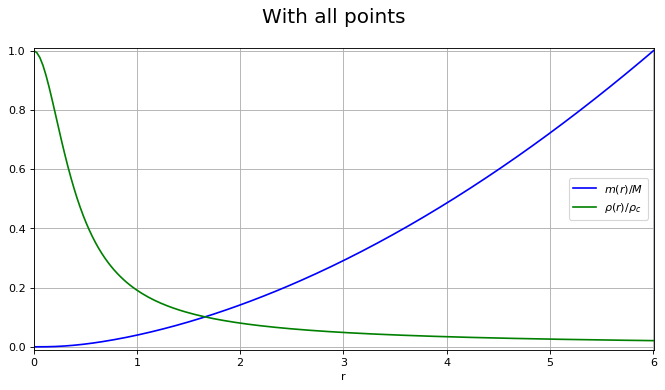

!!!No Star Surface Found!!!
=========Results==========
N_s
Gamma = 0.6666666666666666
Mass = 25.60043839215522
Radius = 6.0
rho_s = 0.013627413314614813


<Figure size 640x320 with 0 Axes>

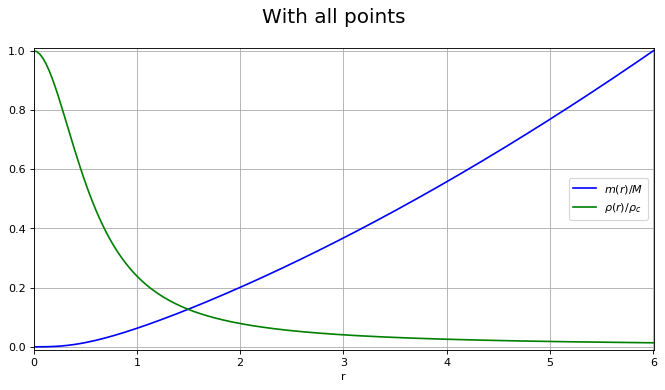

!!!No Star Surface Found!!!
=========Results==========
N_s
Gamma = 1.0
Mass = 13.404483827556255
Radius = 6.0
rho_s = 0.003917718897354269


<Figure size 640x320 with 0 Axes>

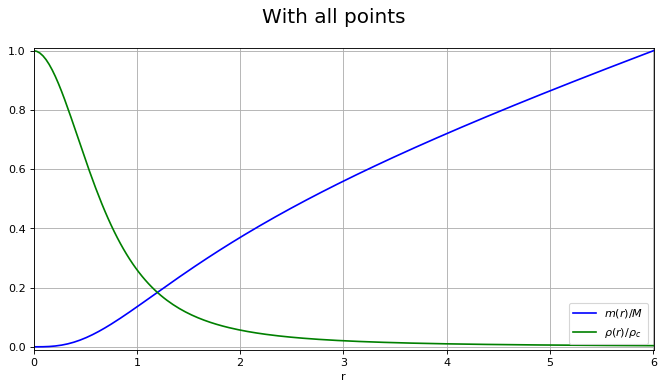

bisection was used
=========Results==========
N_s
Gamma = 1.3333333333333333
Mass = 4.5546710218587645
Radius = 3.8853524999999998
rho_s = 2.3513724300983085e-10


/home/orion/Documents/MTPX_Computational_2018/Astrophysics/Set1/Set1/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 640x320 with 0 Axes>

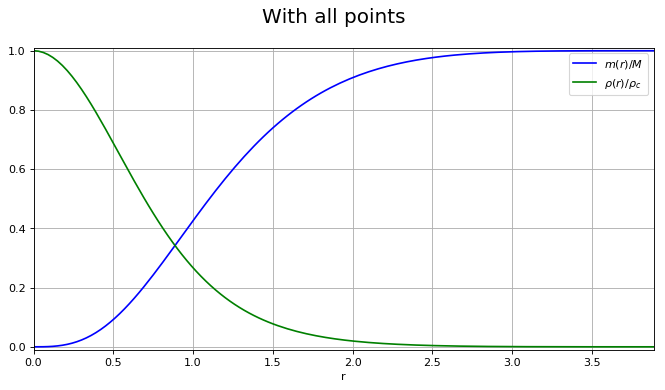

4th order polyfit was used
=========Results==========
N_s
Gamma = 1.6666666666666667
Mass = 3.026125806438671
Radius = 1.64391679054703
rho_s = -0.0003086664755542756


<Figure size 640x320 with 0 Axes>

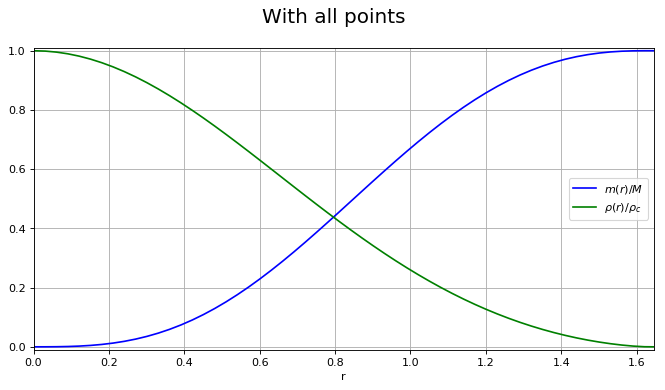

bisection was used
=========Results==========
N_s
Gamma = 2.0
Mass = 2.5112423475698256
Radius = 1.2457924999999999
rho_s = 0.006037344761212093


<Figure size 640x320 with 0 Axes>

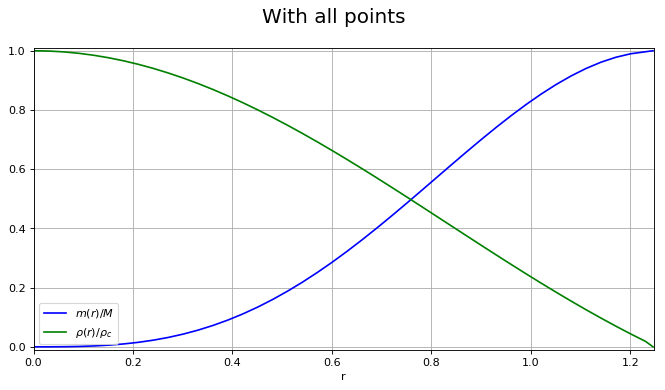

bisection was used
=========Results==========
N_s
Gamma = 2.3333333333333335
Mass = 2.249503954007582
Radius = 1.0958174999999999
rho_s = 0.007962446177202764


<Figure size 640x320 with 0 Axes>

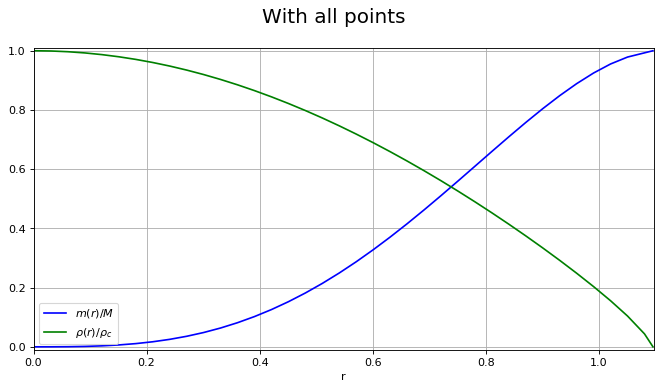

In [47]:
ns_mr(1,1/3,1,0.001,6,201)
ns_mr(1,2/3,1,0.001,6,201)
ns_mr(1,3/3,1,0.001,6,201)
ns_mr(1,4/3,1,0.001,6,201)
ns_mr(1,5/3,1,0.001,6,201)
ns_mr(1,6/3,1,0.001,6,201)
ns_mr(1,7/3,1,0.001,6,201)